# PHYS 503 - Data Acquisition - Dr. Edward Brash
# Anne Haley - Sept 11 2020
# Assignment 1


Question 1: Root finding using the bisection method

In [1]:

import numpy as np
import matplotlib.pyplot as plt

import time
def generator_function(x,*par):
    return par[0]+par[1]*x+par[2]*x*x+par[3]*x*x*x

def bisection_method(xl, xh, npoints, nsearch, *par):
    dx = (xh-xl)/npoints
    xroots = []
    yroots = []
    xval = np.arange(xl,xh,dx)
    yval = generator_function(xval,*par)
    start = time.time()
    niter = npoints/nsearch
    ycomp = yval[0]
    nroots_found = 0
    for i in range(0,int(niter)):
        y = yval[nsearch*i]
        if (y==0):
          xroots.append(xval[nsearch*i])
          yroots.append(0.0)
          nroots_found = nroots_found + 1
        if (y*ycomp<0.0):
          xlow = xval[nsearch*(i-1)]
          xhigh = xval[nsearch*i]
          epsilon = 1.48E-8
          diff = 1.0E12
          while (diff>epsilon):
            fa = generator_function(xlow,*par)
            fb = generator_function(xhigh,*par)
            xmid = (xhigh+xlow)/2.0
            fc = generator_function(xmid,*par)
            product = fa*fc
            if (product < 0):
                xhigh = xmid
            else:
                xlow = xmid
            diff = np.abs(fc)
          xroots.append(xmid)
          yroots.append(0.0)
          nroots_found = nroots_found + 1
          ycomp = y
        else:
          ycomp = y
    end = time.time()
    return (xroots, nroots_found, end-start)

xl = -4.0
xh = 4.0
npoints = 10000
nsearch = 1000
par = np.array([1.80,-4.05,0.4,1.0])
ret_values = bisection_method(xl, xh, npoints, nsearch, *par)
print(ret_values[1],"roots found: ["+", ".join(["%.2f"%root for root in ret_values[0]])+"]", "in %.8f seconds"%ret_values[2])

3 roots found: [-2.40, 0.50, 1.50] in 0.00016642 seconds


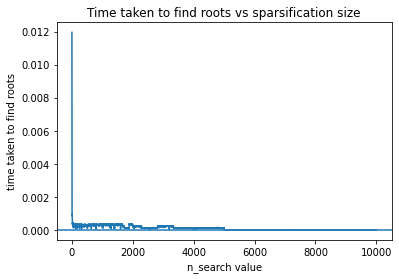

In [2]:
n_search_values_array = range(1, 10000)
time_taken_array = []
for val in n_search_values_array:
  time_taken_array.append(bisection_method(xl, xh, npoints, val, *par)[2])

fig, axs = plt.subplots(nrows=1, ncols=1)
axs.plot(n_search_values_array, time_taken_array)
axs.set_title('Time taken to find roots vs sparsification size')
axs.set_ylabel('time taken to find roots')
axs.set_xlabel('n_search value')
axs.axhline()
plt.show()

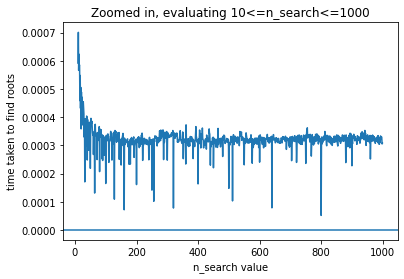

In [3]:
n_search_values_array = range(10, 1000)
time_taken_array = []
for val in n_search_values_array:
  time_taken_array.append(bisection_method(xl, xh, npoints, val, *par)[2])

fig, axs = plt.subplots(nrows=1, ncols=1)
axs.plot(n_search_values_array, time_taken_array)
axs.set_title('Zoomed in, evaluating 10<=n_search<=1000')
axs.set_ylabel('time taken to find roots')
axs.set_xlabel('n_search value')
axs.axhline()
plt.show()

This graph appears to be logarithmic in nature and characterized by spikes. 

It makes sense that it takes a logarithmic shape because this bisection method is a lot like a binary search, which has a time complexity of O(log n). With the bisection method, like binary search, you eliminate 1/2 the possibilities with each iteration.

The spikes are likely caused by the chance that the first search values are close to whatever roots belong to that polynomial function. These numerical differences are reflected by the time it takes to reach the goal state (identified roots) from the start state (the positions of the niter values some distance away from the roots). Changes to the function (and consequently, changes to the goal state) will change the time it takes to reach the goal state from each start state.

Question 2: Fitting Data


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.formula.api as sm
from statsmodels.stats.anova import anova_lm
import scipy.stats as stats
from sklearn.linear_model import LinearRegression

url = 'https://raw.githubusercontent.com/annehaley/phys-503/master/del%20later%20-%20Sheet1.csv'
df = pd.read_csv(url)

altitude = np.array(df['Geo potential Altitude above Sea Level\n- h -\n(m)'][1:])
density = np.array(df['Density\n- ρ -\n(kg/m3)'][1:])


In [5]:
from scipy.optimize import curve_fit
from math import e
import seaborn as sns

def fitfunction(x, a, b, c):
  sqrt_x = x**0.5
  return a*e**(b*x + c*sqrt_x)

def find_best_fit():
  popt, pcov = curve_fit(fitfunction, altitude, density, p0=[0.0,0.0,0.0])
  density_prediction = fitfunction(altitude, *popt)

  print('Parameters:')
  for i, x in enumerate(['A', 'B', 'C']):
    print('{} = {:e},\terror = {:e}'.format(x, popt[i], (pcov[i][i])**0.5))

  xi = np.linspace(np.min(altitude),np.max(altitude),100)
  ps = np.random.multivariate_normal(popt,pcov,10000)
  ysample=np.asarray([fitfunction(xi,*pi) for pi in ps])
  lower = np.percentile(ysample,2.5,axis=0)
  upper = np.percentile(ysample,97.5,axis=0)
  return (density_prediction, xi, lower, upper)

density_prediction, xi, lower, upper = find_best_fit()

Parameters:
A = 1.210247e+00,	error = 1.501549e-02
B = -1.306129e-04,	error = 5.239846e-06
C = 2.063425e-03,	error = 5.212601e-04


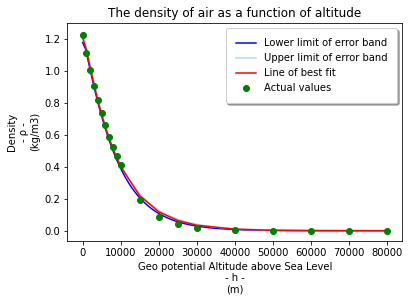

In [6]:
plt.plot(xi,lower, color='blue', label='Lower limit of error band')
plt.plot(xi,upper, color='lightblue', label='Upper limit of error band')

plt.plot(altitude, density_prediction, color='red', label='Line of best fit')
plt.plot(altitude, density, 'o', color='green', label='Actual values')

plt.ylabel('Density\n- ρ -\n(kg/m3)')
plt.xlabel('Geo potential Altitude above Sea Level\n- h -\n(m)')
plt.title('The density of air as a function of altitude')

plt.legend(fancybox=True, shadow=True, borderpad=1)
plt.show()


Upon first glance, this seems like a great fit. There is little visible gap between the actual values and the red line of best fit. However, this model does not consider the difference in scale of the y-values. The greater values at low altitudes eclipse the weight of the lesser values at high altitudes, and the curve_fit function prioritizes fitting higher values in order to reduce the magnitude of chi squared.

This could be addressed by looking at the graph at a logarithmic scale:

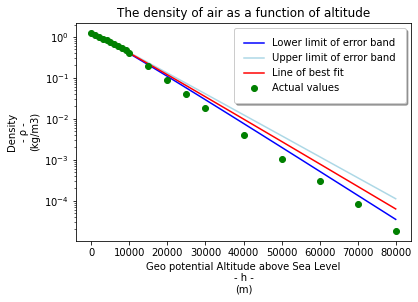

In [7]:
plt.plot(xi,lower, color='blue', label='Lower limit of error band')
plt.plot(xi,upper, color='lightblue', label='Upper limit of error band')

plt.plot(altitude, density_prediction, color='red', label='Line of best fit')
plt.plot(altitude, density, 'o', color='green', label='Actual values')

plt.ylabel('Density\n- ρ -\n(kg/m3)')
plt.xlabel('Geo potential Altitude above Sea Level\n- h -\n(m)')
plt.title('The density of air as a function of altitude')

plt.legend(fancybox=True, shadow=True, borderpad=1)
plt.yscale('log')
plt.show()


With this adjusted scale, it is clear that the fit prioritizes higher values and misses lower values. We can recalculate the fit at this adjusted scale to get a new line of best fit.

Parameters:
A = -6.406647e-02,	error = 1.576479e-02
B = -4.946143e-05,	error = 5.206381e-06
C = 3.203761e-02,	error = 2.285564e-03


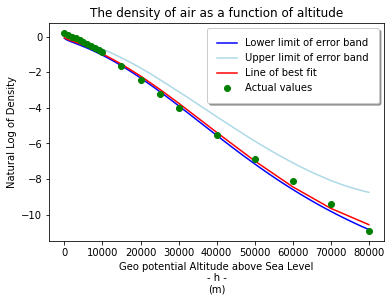

In [8]:
import math
density = [math.log(d) for d in density]

density_prediction, xi, lower, upper = find_best_fit()

plt.plot(xi,lower, color='blue', label='Lower limit of error band')
plt.plot(xi,upper, color='lightblue', label='Upper limit of error band')

plt.plot(altitude, density_prediction, color='red', label='Line of best fit')
plt.plot(altitude, density, 'o', color='green', label='Actual values')

plt.ylabel('Natural Log of Density')
plt.xlabel('Geo potential Altitude above Sea Level\n- h -\n(m)')
plt.title('The density of air as a function of altitude')

plt.legend(fancybox=True, shadow=True, borderpad=1)
plt.show()

This new line of best fit is visibly closer to the last few points than the old model. However, with this new scale, the upper limit of the error band appears further from the last few actual values.